In [1]:
torch.device('cuda')

NameError: name 'torch' is not defined

In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import init
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np
import torch.utils.data

from IPython.display import HTML
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torch
from functools import partial

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / torch.Tensor([d_model]) * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [T, d_model // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [T, d_model // 2, 2]
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb


class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x


class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x


class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            nn.GELU(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            nn.GELU(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h


class UNet(nn.Module):
    def __init__(self, T, ch=128, ch_mult=[1,2,2,2], attn=[1], num_res_blocks=2, dropout=0.1):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(1, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            nn.GELU(),
            nn.Conv2d(now_ch, 1, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

In [ ]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''

        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = UNet(T)

        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss


    def forward(self, x, idx=None, get_target=False):
        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None, None, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon

        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x



        output = self.backbone(x_tilde, idx)

        return (output, epsilon, used_alpha_bars) if get_target else output

In [ ]:
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        '''
        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape

        self.diffusion_fn = diffusion_fn
        self.device = device


    def _one_diffusion_step(self, x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):

            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)

            x = mu_theta_xt + sqrt_tilde_beta * noise

            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step
        '''
        sample = torch.randn([sampling_number,*self.shape]).to(device = self.device)
        sampling_list = []

        final = None
        for sample in self._one_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

In [ ]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]

        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [ ]:
def imshow(sample, sampling_number = 64):
    plt.figure(figsize=(10, 10))
    clear_output()
    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255

    show_sample = show_sample.astype(np.uint8)
    plt.axis(False)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()

In [ ]:
beta_1 = 1e-4
beta_T = 0.02
T = 500
shape = (1, 16, 16)
device = torch.device('cuda')

model = Model(device, beta_1, beta_T, T)
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
optim = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
total_iteration = 2000
current_iteration = 0
display_iteration = 500

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((shape[-2], shape[-1])),
    torchvision.transforms.ToTensor()
])

sampling_number = 16
only_final = True

In [ ]:
dataset = torchvision.datasets.MNIST(root = './MNIST', train=True, download=True, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 128, drop_last = True, num_workers = 0)
dataiterator = iter(dataloader)

In [ ]:
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

In [ ]:
while current_iteration != total_iteration:
    try:
        data = dataiterator.__next__()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.__next__()
    data = data[0].to(device = device)
    loss = model.loss_fn(data)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.update(loss.item())
    progress.display(current_iteration)
    current_iteration += 1

    if current_iteration % display_iteration == 0:
        process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
        sample = process.sampling(sampling_number, only_final)
        #imshow(sample, sampling_number)

        losses.reset()

Iteration [1999/2000]	Loss 0.0252 (0.0300)

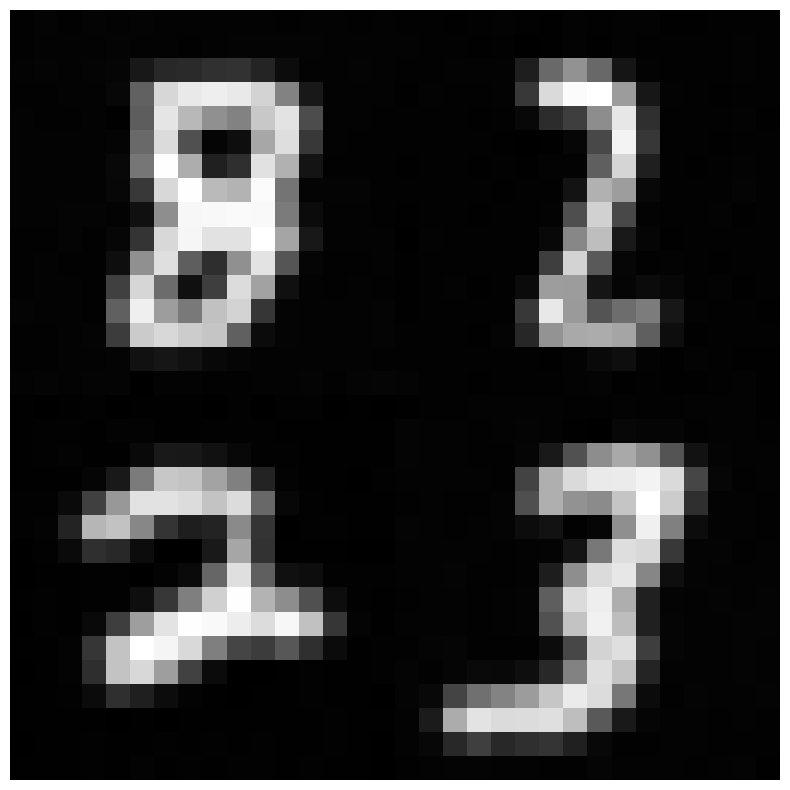

In [ ]:
sampling_number = 4
only_final = True
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
sample = process.sampling(sampling_number, only_final)
imshow(sample, sampling_number)

In [ ]:
def ani_imshow(sample, sampling_number = 64):

    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255

    show_sample = show_sample.astype(np.uint8)

    return show_sample

In [ ]:
sampling_number = 4
only_final = False
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
sample = process.sampling(sampling_number, only_final)

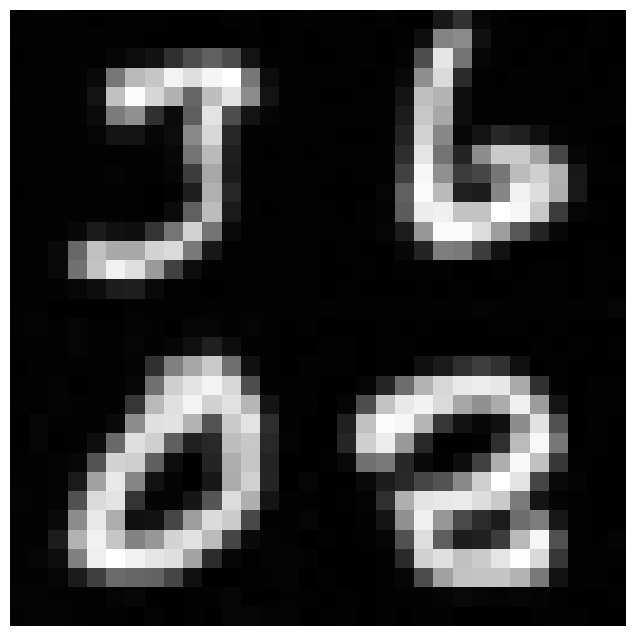

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
show_sample = sample[9::10]
ims = [[plt.imshow(ani_imshow(show_sample[i], sampling_number = sampling_number), animated=True, cmap = 'gray')] for i in range(len(show_sample))]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

writergif = animation.PillowWriter(fps=50)
ani.save('ddpm_mnist.gif', writer=writergif)

HTML(ani.to_jshtml())